# Fun With Word2Vec: News Headlines

In this notebook, we will:
* Clean text data (news article titles and headlines from [this paper](https://www.researchgate.net/publication/322652391_Multi-Source_Social_Feedback_of_Online_News_Feeds))
* Use Word2Vec to create word embeddings, and visualize word clusters on a t-SNE plot
* Do the same with titles, by averaging the word vectors in each title
* Train a model based on title embedding, topic, time since publishing, and sentiment, in order to predict the article's popularity on each platform

In [12]:
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
main_data = pd.read_csv('News_Final.csv')

In [3]:
main_data.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


# Preprocessing

We'll start by doing some cleaning and manipulation on the text data. In particular, we need to:
1. Get individual words from article titles
2. Use NLTK to filter out stopwords, punctuation, and any words that are not known to Word2Vec
3. Turn the words into vector representations using Word2Vec

In [4]:
# Grab all the article titles
article_titles = main_data['Title']
article_titles.shape

(93239,)

In [5]:
# Create a list of strings, where each string is an article title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['obama',
 'lays',
 'wreath',
 'arlington',
 'national',
 'cemetery',
 'look',
 'health',
 'chinese',
 'economy']

In [6]:
# Load Word2Vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size

300

What a word vector looks like:

In [7]:
economy_vec = model['economy']
economy_vec[:20] # First 20 components

array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047],
      dtype=float32)

In [8]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

(21805, 300)

Now we have a bunch of tidy vectors in a DataFrame. Each column is the word's component for that dimension (300 dimensions total).

In [9]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
obama,-0.123535,0.072266,0.171875,0.402344,-0.125977,-0.302734,-0.044922,-0.015259,0.171875,-0.043457,...,-0.055420,-0.138672,-0.064453,-0.104004,-0.267578,-0.205078,-0.111816,-0.022461,0.066895,0.026855
lays,-0.052246,-0.057373,0.193359,-0.106934,0.298828,-0.166016,0.137695,0.125000,-0.032227,-0.096191,...,-0.172852,-0.484375,-0.228516,0.168945,-0.291016,0.003647,0.041016,0.229492,0.248047,0.353516
wreath,0.166992,0.199219,-0.082031,0.142578,0.055420,-0.102539,0.103516,-0.138672,0.030884,-0.007050,...,0.015503,-0.085938,-0.173828,0.109863,0.096680,-0.102051,0.119629,-0.287109,-0.085938,0.188477


# Dimensionality Reduction: t-SNE

Next, we're going to squish (read: do dimensionality reduction on) these word vectors using t-SNE. If you're not familiar with t-SNE and its interpretations, check out [this excellent, interactive distill.pub article](https://distill.pub/2016/misread-tsne/) on t-SNE. 

It's important to play around with the parameters for t-SNE, as different values can produce very different results. I tested several values between 0 and 100 for perplexity, and found that it produced roughly the same shape each time. I tested several learning rates between 20 and 400 as well, and decided to leave the learning rate at its default (200).

In [10]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

Now we're ready to plot our reduced array of word vectors and see what patterns we can find.

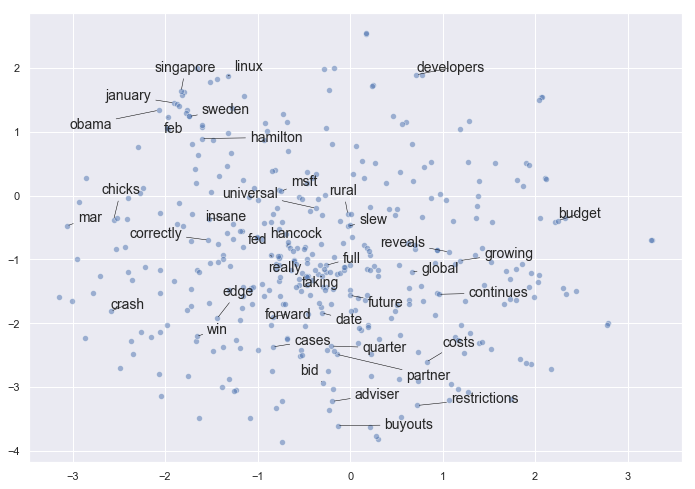

In [14]:
sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Note that even though the text still overlaps some points, we no longer have overlapping text. Nifty! 

If you're interested in trying out `adjust_text` for your own plotting needs, you can find it [here](https://github.com/Phlya/adjustText). Be sure to import using the camelcase `adjustText`, and please note that `adjustText` is currently not compatible with matplotlib 3.0 or higher.

It's encouraging to see that even when the vector embeddings have been reduced to 2 dimensions, we see certain items clustering together. For example, we have **months** in the left/upper left, we have **corporate finance terms** near the bottom, and we have more **generic, non-topical words** (like 'full', 'really', 'slew') in the middle.

Note that if we were to run the t-SNE again with different parameters, we may observe some similarities to this result, but we're not guaranteed to see the exact same patterns. t-SNE, as compared to PCA, is not deterministic. Relatedly, tightness of clusters and distances between clusters are not always meaningful. It is meant primarily as an exploratory tool, rather than as a decisive indicator of similarity. 

# Averaging Word Embeddings 

We've gotten a sense of how word embeddings work as applied to this dataset. Now we can move on to some more interesting ML applications: finding titles that cluster together, and seeing what patterns emerge.

Instead of using Doc2Vec, which would require a lengthy training process, we can use a simpler [(and sometimes even more effective)](https://stackoverflow.com/questions/45234310/doc2vec-worse-than-mean-or-sum-of-word2vec-vectors) trick: averaging the embeddings of the word vectors in each document. In our case, a document refers to a title or a headline. 

In [15]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [16]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

37 docs removed
0 docs removed


In [17]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

Procedure and functions adapted from [this notebook](https://github.com/sdimi/average-word2vec/blob/master/notebook.ipynb) by Dimitris Spathis.

# t-SNE for Document Vectors

In [18]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])

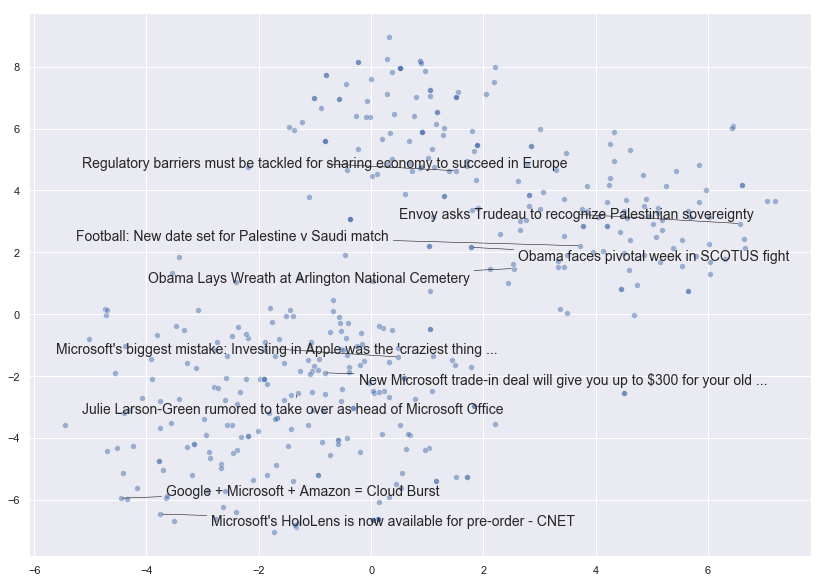

In [19]:
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Pretty interesting! We can see that the t-SNE has collapsed the document vectors into a dimensional space where the documents are spread out based on whether their content has more to do with countries, world leaders, and foreign affairs, or has more to do with technology companies. 

In [20]:
# Drop all the rows where the article popularities are unknown (this is only about 11% of the data)
main_data = main_data.drop(main_data[(main_data.Facebook == -1) | 
                                     (main_data.GooglePlus == -1) | 
                                     (main_data.LinkedIn == -1)].index)

# Also drop all rows where we don't know the source
main_data = main_data.drop(main_data[main_data['Source'].isna()].index)

main_data.shape

(81417, 11)

# Popularity Analysis

We still have 81,000 rows left to work with. 

Let's see if we can find any associations between sentiment and number of shares.

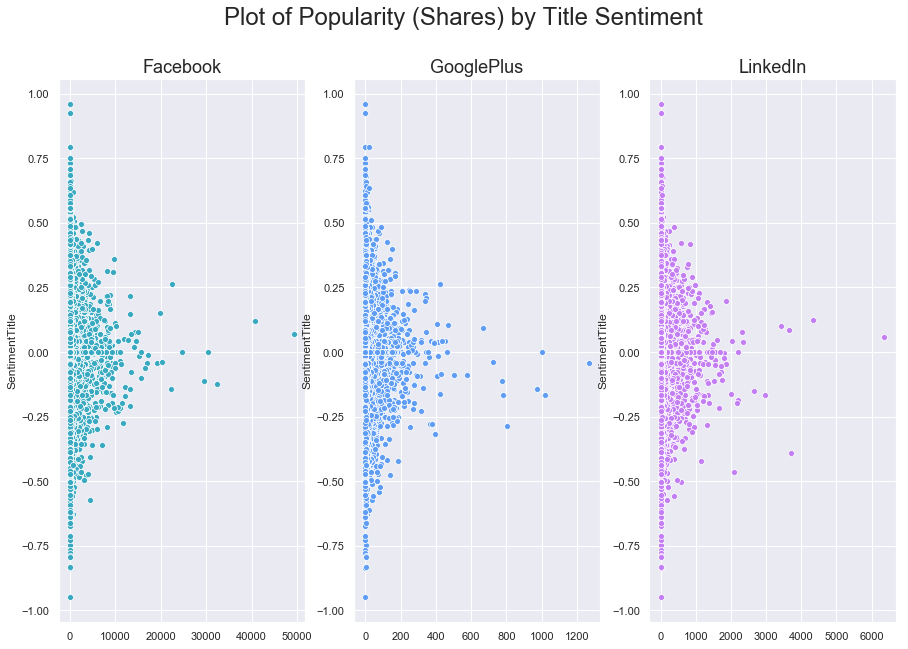

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]
platforms = ['Facebook', 'GooglePlus', 'LinkedIn']
colors = list(sns.husl_palette(10, h=.5)[1:4]) 

for platform, subplot, color in zip(platforms, subplots, colors):
    sns.scatterplot(x = main_data[platform], y = main_data['SentimentTitle'], ax=subplot, color=color)
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity (Shares) by Title Sentiment', fontsize=24)

plt.show()

It's a bit hard to make out whether there's any relationship here, since a few articles are significant outliers in terms of their share counts. Let's try log-transforming the x-axis to see if we can reveal any patterns.

/Users/charlenechambliss/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


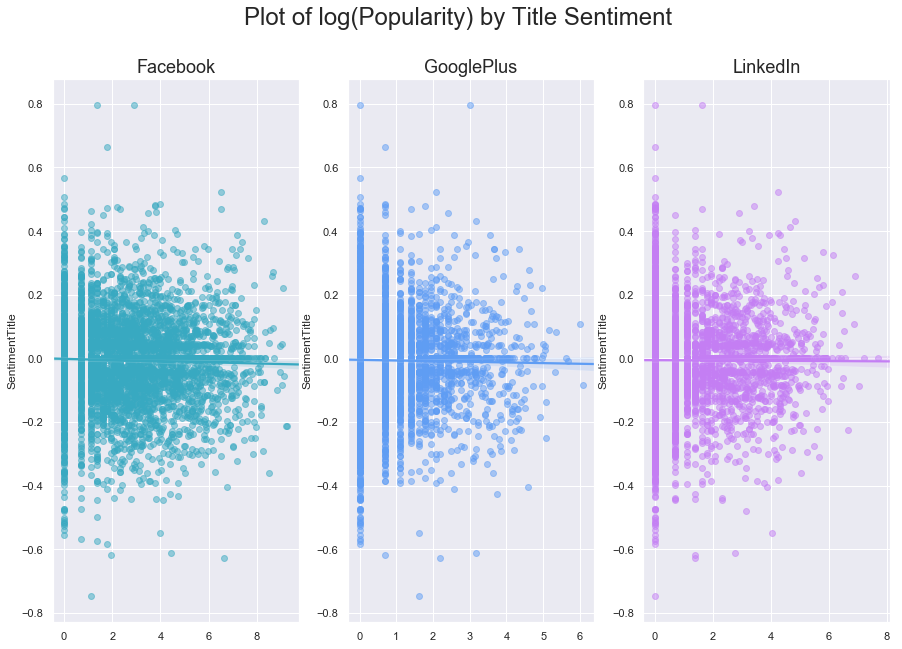

In [22]:
# Our data has over 80,000 rows, so let's subsample it to make the log-transformed scatterplot easier to read

subsample = main_data.sample(5000)

fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]

for platform, subplot, color in zip(platforms, subplots, colors):
    # Regression plot, so we can gauge the linear relationship
    sns.regplot(x = np.log(subsample[platform] + 1), y = subsample['SentimentTitle'], 
                ax=subplot, 
                color=color,
                # Pass an alpha value to regplot's scatterplot call
                scatter_kws={'alpha':0.5})
    
    # Set a nice title, get rid of x labels
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of log(Popularity) by Title Sentiment', fontsize=24)

plt.show()

Contrary to what we might expect (from our idea of highly emotional, clickbaity headlines), in this dataset we find no relationship between headline sentiment and article popularity as measured by number of shares. 

In [28]:
import datetime

# Convert publish date column to make it compatible with other datetime objects

main_data['PublishDate'] = pd.to_datetime(main_data['PublishDate'])

# Time since Linux Epoch
t = datetime.datetime(1970, 1, 1)

# Subtract this time from each article's publish date
main_data['TimeSinceEpoch'] = main_data['PublishDate'] - t

# Create another column for just the days from the timedelta objects 
main_data['DaysSinceEpoch'] = main_data['TimeSinceEpoch'].astype('timedelta64[D]')

main_data['TimeSinceEpoch'].describe()

count                         81417
mean     16859 days 20:08:20.439011
std         64 days 18:03:50.779344
min             16747 days 05:25:00
25%             16805 days 20:54:00
50%             16857 days 06:04:23
75%             16913 days 08:15:00
max             16989 days 15:59:22
Name: TimeSinceEpoch, dtype: object

So it looks like all of the articles were published within about a 200-day window.

# Sentiment Analysis

/Users/charlenechambliss/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


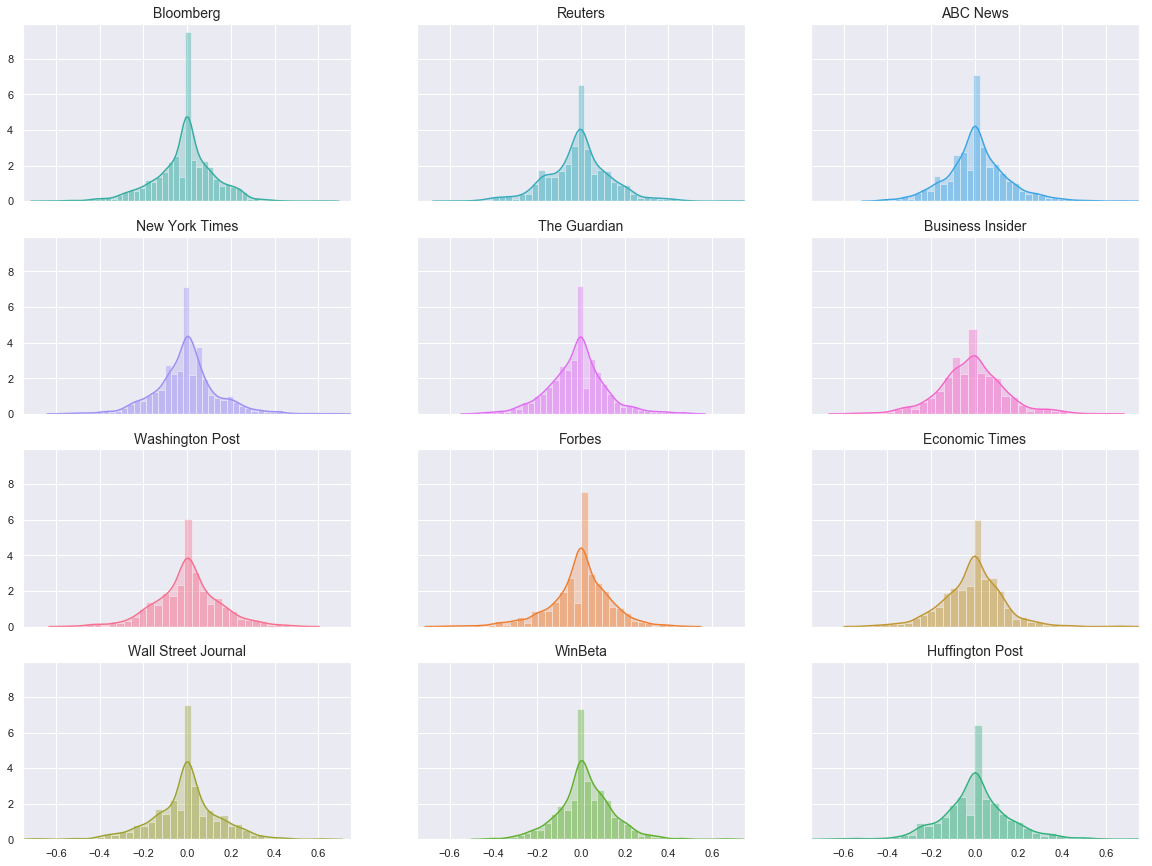

In [29]:
# Get the list of top 12 sources by number of articles
source_names = list(main_data['Source'].value_counts()[:12].index)
source_colors = list(sns.husl_palette(12, h=.5))

fig, ax = plt.subplots(4, 3, figsize=(20, 15), sharex=True, sharey=True)

ax = ax.flatten()
for ax, source, color in zip(ax, source_names, source_colors):
    sns.distplot(main_data.loc[main_data['Source'] == source]['SentimentTitle'],
                               ax=ax, color=color, kde_kws={'shade':True})
    ax.set_title(source, fontsize=14)
    ax.set_xlabel('')
    
plt.xlim(-0.75, 0.75)
plt.show()

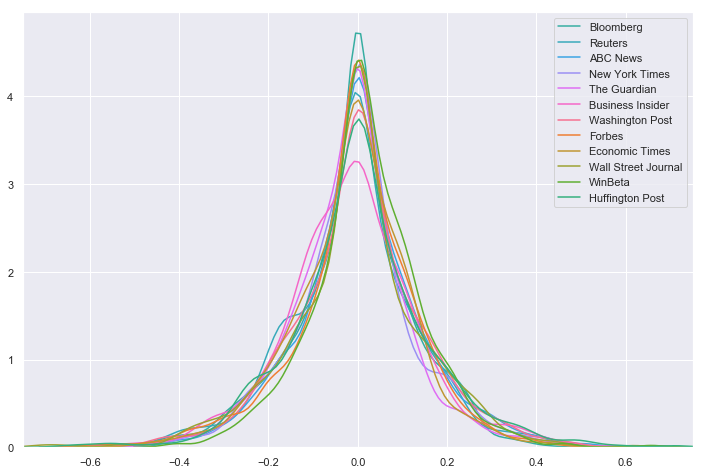

In [30]:
# Overlay each density curve on the same plot for closer comparison

fig, ax = plt.subplots(figsize=(12, 8))

for source, color in zip(source_names, source_colors):
    sns.distplot(main_data.loc[main_data['Source'] == source]['SentimentTitle'],
                               ax=ax, hist=False, label=source, color=color)
    ax.set_xlabel('')
    
plt.xlim(-0.75, 0.75)
plt.show()

By overlaying the density estimates onto the same plot, we can get a better idea of how their shapes differ than trying to compare each plot to the other. 

We see that the sources' Sentiment distributions (for article titles) are very similar - it doesn't look like any one source is an outlier in terms of positive or negative headlines. Instead, all 12 of the most common sources have distributions centered around 0 with modestly sized tails.

# Popularity Prediction

Our exploratory visualizations may not have yielded much to work from, but we can still see if there are any non-visual patterns we've missed that a model might discover. Our first task in preparing the data for modeling is to rejoin the document vectors with their respective titles. Thankfully, when we were preprocessing the corpus, we processed the `corpus` and `titles_list` simultaneously, so the vectors and the titles they represent will still match up. Meanwhile, in `main_df`, we have dropped all of the articles that had -1 popularity, so we'll need to drop the vectors that represent those article titles.

Training a model on these enormous vectors as-is will not be possible on this computer, but we'll see what we can do with a little dimension reduction.

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15, random_state=10)

# x is the array with our 300-dimensional vectors
reduced_vecs = pca.fit_transform(x)

In [67]:
df_w_vectors = pd.DataFrame(reduced_vecs)

df_w_vectors['Title'] = titles_list

main_w_vectors = pd.concat((df_w_vectors, main_data), axis=1)

# Get rid of vectors that couldn't be matched with the main_df
main_w_vectors.dropna(axis=0, inplace=True)

main_w_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,TimeSinceEpoch,DaysSinceEpoch
726,0.610009,-0.378075,-0.134921,0.009630,0.104041,0.144502,-0.154376,-0.164918,0.007274,-0.028512,...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0.0,0.0,0.0,16747 days 05:25:00,16747.0
727,-0.540840,-0.411312,-0.179411,-0.234008,0.080068,-0.047119,-0.128647,-0.044599,-0.006016,-0.173711,...,IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0.0,0.0,0.0,16747 days 05:40:00,16747.0
728,-0.540840,-0.411312,-0.179411,-0.234008,0.080068,-0.047119,-0.128647,-0.044599,-0.006016,-0.173711,...,IANS via Yahoo Maktoob News,economy,2015-11-08 05:48:00,-0.082022,0.186968,0.0,0.0,0.0,16747 days 05:48:00,16747.0
729,0.497476,-0.475604,-0.159985,-0.162602,0.012534,0.077912,-0.078580,-0.061363,-0.139491,0.058723,...,The Columbian,microsoft,2015-11-08 06:54:00,0.106303,-0.207333,0.0,0.0,0.0,16747 days 06:54:00,16747.0
730,-0.160366,-0.275578,0.342931,0.120123,0.155041,0.243502,0.174798,0.224570,-0.021191,0.018534,...,The Borneo Post,economy,2015-11-08 08:34:00,0.000000,0.003189,1.0,0.0,0.0,16747 days 08:34:00,16747.0


In [68]:
# All of the columns have been successfully appended 
list(main_w_vectors.columns)[-13:]

['IDLink',
 'Title',
 'Headline',
 'Source',
 'Topic',
 'PublishDate',
 'SentimentTitle',
 'SentimentHeadline',
 'Facebook',
 'GooglePlus',
 'LinkedIn',
 'TimeSinceEpoch',
 'DaysSinceEpoch']

In [82]:
# Drop all non-numeric, non-dummy columns, for feeding into the models
cols_to_drop = ['IDLink', 'Title', 'TimeSinceEpoch', 'Headline', 'PublishDate', 'Source'] 

data_only_df = pd.get_dummies(main_w_vectors, columns = ['Topic']).drop(columns=cols_to_drop)

# Standardize DaysSinceEpoch since the raw numbers are larger in magnitude 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Reshape so we can feed the column to the scaler
standardized_days = np.array(data_only_df['DaysSinceEpoch']).reshape(-1, 1)
data_only_df['StandardizedDays'] = scaler.fit_transform(standardized_days)

# Drop the raw column; we don't need it anymore
data_only_df.drop(columns=['DaysSinceEpoch'], inplace=True)

# Look at the new range
data_only_df['StandardizedDays'].describe()

count    8.139800e+04
mean    -6.155442e-14
std      1.000006e+00
min     -1.734555e+00
25%     -8.386800e-01
50%     -3.548197e-02
75%      8.295005e-01
max      2.003405e+00
Name: StandardizedDays, dtype: float64

In [83]:
# Create individual DataFrames for each platform's regression task
fb_data_only_df = data_only_df.drop(columns=['GooglePlus', 'LinkedIn'])
goog_data_only_df = data_only_df.drop(columns=['Facebook', 'LinkedIn'])
li_data_only_df = data_only_df.drop(columns=['Facebook', 'GooglePlus'])

# Facebook Popularity

In [85]:
from sklearn.model_selection import train_test_split

X = fb_data_only_df.drop('Facebook', axis=1)
y = fb_data_only_df['Facebook']

# 70% of data goes to training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [86]:
import xgboost as xgb

# Instantiate the XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=1)

In [90]:
for feature, importance in zip(list(X.columns), xgr.feature_importances_):
    print('Model weight for feature {}: {}'.format(feature, importance))
    
    # TODO: create a plot for this

Model weight for feature 0: 0.10798816382884979
Model weight for feature 1: 0.03698224946856499
Model weight for feature 2: 0.03550295904278755
Model weight for feature 3: 0.05325443670153618
Model weight for feature 4: 0.008875739760696888
Model weight for feature 5: 0.057692307978868484
Model weight for feature 6: 0.044378697872161865
Model weight for feature 7: 0.05325443670153618
Model weight for feature 8: 0.044378697872161865
Model weight for feature 9: 0.028106508776545525
Model weight for feature 10: 0.10946745425462723
Model weight for feature 11: 0.041420117020606995
Model weight for feature 12: 0.0458579882979393
Model weight for feature 13: 0.03402366861701012
Model weight for feature 14: 0.03994082659482956
Model weight for feature SentimentTitle: 0.028106508776545525
Model weight for feature SentimentHeadline: 0.031065089628100395
Model weight for feature Topic_economy: 0.0
Model weight for feature Topic_microsoft: 0.001479289960116148
Model weight for feature Topic_obama

In [91]:
from sklearn.metrics import mean_squared_error

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

360639.4372872859

Hyperparameter grid from [here](https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv)

In [94]:
from sklearn.model_selection import GridSearchCV

# Various hyper-parameters to tune
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:  2.4min finished


0.004352557045698313
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [96]:
params = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 
          'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

# Try again with new params
xgr = xgb.XGBRegressor(random_state=2, **params)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=5, min_child_weight=4, missing=None, n_estimators=500,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=2,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7)

In [97]:
y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

# Well, it -is- better than the base model by about 30,000.

330115.8290426749

In [98]:
for feature, importance in zip(list(X.columns), xgr.feature_importances_):
    print('Model weight for feature {}: {}'.format(feature, importance))

Model weight for feature 0: 0.053443364799022675
Model weight for feature 1: 0.04764711484313011
Model weight for feature 2: 0.035268690437078476
Model weight for feature 3: 0.05865016207098961
Model weight for feature 4: 0.03811769187450409
Model weight for feature 5: 0.05923961102962494
Model weight for feature 6: 0.04764711484313011
Model weight for feature 7: 0.04833480715751648
Model weight for feature 8: 0.050987325608730316
Model weight for feature 9: 0.05432753637433052
Model weight for feature 10: 0.08045977354049683
Model weight for feature 11: 0.04578052833676338
Model weight for feature 12: 0.05118380859494209
Model weight for feature 13: 0.043226249516010284
Model weight for feature 14: 0.05020139366388321
Model weight for feature SentimentTitle: 0.03733175992965698
Model weight for feature SentimentHeadline: 0.05422929674386978
Model weight for feature Topic_economy: 0.010217113420367241
Model weight for feature Topic_microsoft: 0.0054032811895012856
Model weight for feat

To be continued - next we'll be cleaning up this model fitting and testing process and creating models for LinkedIn and GooglePlus.